# Supplementary Material B: Section 2.4

# Atmospheric Stability Class Determination
-------------------------------------------------

Here we compare the CH4 concentration measured by the different reflectors to the models' predictions. Plotting the the measured CH4 as a function of beam intersections' downwind distance and comparing it to the models' predictions helps to determine which model best approximates reality.

We identify a slice of data when the wind direction covers all beams and preferably cuts them perpendicularly. Using this interval we compute 1) the average wind direction and determine the distance between the source and plume intersection to the different beams for that mean wind direction, 2) the interval mean CH4 measurements for each beams. This gives us seven distances and seven average CH4 beams measurements.



<div class="alert alert-block alert-warning">
<b>PACKAGE REQUIREMENT:</b> Package "sourceinversion". Install using:<br>
pip install -q sourceinversion
</div>

In [1]:
# pip install -q sourceinversion

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/...
</div>

<br><br><br>

### Importing "sourceinversion" package 

In [2]:
from sourceinversion import atmospheric_measurements as gp

### Libraries

In [3]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

### Chilbolton sensor layout

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace with your own local path to sensor location data. The file is located in:

Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Sensor_reflector_locations/Chilbolton_instruments_location.pkl
</div>

In [4]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Sensor_reflector_locations/Chilbolton_instruments_location.pkl', 'rb') as f:
    instruments_location = pickle.load(f)

number_of_point_sensors = {
    "reflector_1": 18*5,
    "reflector_2": 33*5,
    "reflector_3": 22*5,
    "reflector_4": 49*5,
    "reflector_5": 42*5,
    "reflector_6": 29*5,
    "reflector_7": 17*5,
}

def get_equally_spaced_points(point1, point2, num_points):
    # Calculate the step size for each dimension
    step_size = [(p2 - p1) / (num_points - 1) for p1, p2 in zip(point1, point2)]

    # Calculate the coordinates of the equally spaced points
    points = [[p1 + i * step for p1, step in zip(point1, step_size)] for i in range(num_points)]

    return points

point_sensors_1_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_1"], number_of_point_sensors["reflector_1"])
point_sensors_2_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_2"], number_of_point_sensors["reflector_2"])
point_sensors_3_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_3"], number_of_point_sensors["reflector_3"])
point_sensors_4_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_4"], number_of_point_sensors["reflector_4"])
point_sensors_5_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_5"], number_of_point_sensors["reflector_5"])
point_sensors_6_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_6"], number_of_point_sensors["reflector_6"])
point_sensors_7_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_7"], number_of_point_sensors["reflector_7"])

def flatten_list_of_lists(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

sensors_settings =  gp.SensorsSettings(
    layout=None,
    sensor_number = jnp.array(7),
    measurement_error_var = jnp.array(1e-6),
    sensor_seed = jnp.array(5),
    measurement_error_seed = jnp.array(420),
    sensor_locations =  flatten_list_of_lists([point_sensors_1_location, point_sensors_2_location, point_sensors_3_location, point_sensors_4_location, point_sensors_5_location, point_sensors_6_location, point_sensors_7_location]), 
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Chilbolton sources

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace with your own local path to source location data. The file is located in:

Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_locations/Chilbolton_sources_locations_and_emission_rates.pkl
</div>

In [5]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_locations_and_emission_rates/Chilbolton_sources_locations_and_emission_rates.pkl', 'rb') as f:
    sources = pickle.load(f)

In [6]:
grid = gp.Grid(
    x_range = (jnp.array(40.0), jnp.array(80.0)), 
    y_range = (jnp.array(0.0), jnp.array(110.0)),
    z_range= (jnp.array(0.0), jnp.array(0.0)),
    dx = jnp.array(10),
    dy = jnp.array(10),
    dz = jnp.array(1),
)

### Python Functions

In [7]:
# Wind direction line coordinates function
def wind_direction_line(point, degree, length=20):
    # Convert degree to radians
    rad = np.deg2rad(degree)

    # Calculate end point
    end_point = (point[0] + length * np.cos(rad), point[1] + length * np.sin(rad))

    return end_point


# Downwind distance intersection between source and beam
def downwind_distance(source, point, wind_direction):
    wind_direction = jnp.deg2rad(wind_direction % 360)

    return jnp.cos(wind_direction) * (point[0] - source[0]) + jnp.sin(wind_direction) * (point[1] - source[1])



# Line intersection and distance function
def line_intersection_and_distance(line1_point1, line1_point2, line2_point1, line2_point2, wind_direction):
    x1, y1 = line1_point1
    x2, y2 = line1_point2
    x3, y3 = line2_point1
    x4, y4 = line2_point2

    px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / ((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
    py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / ((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))

    intersection_point = (px, py)

    # Compute the distance between line1_point1 and the intersection point
    distance = downwind_distance(line1_point1, intersection_point, wind_direction)

    return intersection_point, distance

<br><br><br><br><br><br>

### Source 1

#### Data

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace with your own local path to source location data. The file is located in:

Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_1/...
</div>

In [8]:
# Load the data
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_1/Chilbolton_CH4_measurements_source_1.pkl', 'rb') as f:
    observations = pickle.load(f)
data_scr1 = observations.values
# Load the wind field and rolling standard deviation of the horizontal and vertical wind direction.
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_1/Chilbolton_windfield_source_1.pkl', 'rb') as f:
    tangamma_ts = pickle.load(f)
    wind_field_scr1 = tangamma_ts[['Average Speed', 'Average Direction']]

#### Setting up

In [9]:

source1_location = gp.SourceLocation(
    source_location_x = jnp.array([sources["source_1_location"][0]]),
    source_location_y = jnp.array([sources["source_1_location"][1]]),
    source_location_z = jnp.array([sources["source_1_location"][2]]),
)


atmospheric_state = gp.AtmosphericState(
    emission_rate = jnp.array(sources["source_1_emission_rate"]),                
    source_half_width = jnp.array(1.0),                                     # source is a square of 2m side length
    max_abl = jnp.array(1000.0),
    background_mean = jnp.array(2.0),       
    background_std = jnp.array(1e-2),       
    background_seed = jnp.array(56),
    background_filter = "power_law",        
    Gaussian_filter_kernel = 1,              
    horizontal_opening_angle= 10.0,
    vertical_opening_angle = 10.0,
    a_horizontal = 1.0,
    a_vertical = 1.0,          
    b_horizontal = 1.0,         
    b_vertical = 1.0,        
)

# Gaussian plume model
gaussianplume_scr1 = gp.GaussianPlume(grid, source1_location, wind_field_scr1, atmospheric_state, sensors_settings)
fixed  = gaussianplume_scr1.fixed_objects_of_gridfree_chilbolton_coupling_matrix(simulation = False, wind_direction=wind_field_scr1["Average Direction"].values, wind_speed=wind_field_scr1["Average Speed"].values, tangamma_ts = tangamma_ts, number_of_time_steps=wind_field_scr1.shape[0])
fixed_ref1 = fixed[0], fixed[7], fixed[14], fixed[15], fixed[35], fixed[36], fixed[16], fixed[37], fixed[44]
fixed_ref2 = fixed[1], fixed[8], fixed[17], fixed[18], fixed[35], fixed[36], fixed[19], fixed[38], fixed[45]
fixed_ref3 = fixed[2], fixed[9], fixed[20], fixed[21], fixed[35], fixed[36], fixed[22], fixed[39], fixed[46]
fixed_ref4 = fixed[3], fixed[10], fixed[23], fixed[24], fixed[35], fixed[36], fixed[25], fixed[40], fixed[47]
fixed_ref5 = fixed[4], fixed[11], fixed[26], fixed[27], fixed[35], fixed[36], fixed[28], fixed[41], fixed[48]
fixed_ref6 = fixed[5], fixed[12], fixed[29], fixed[30], fixed[35], fixed[36], fixed[31], fixed[42], fixed[49]
fixed_ref7 = fixed[6], fixed[13], fixed[32], fixed[33], fixed[35], fixed[36], fixed[34], fixed[43], fixed[50]

#### Source 1 Atmospheric Stability Class Determination

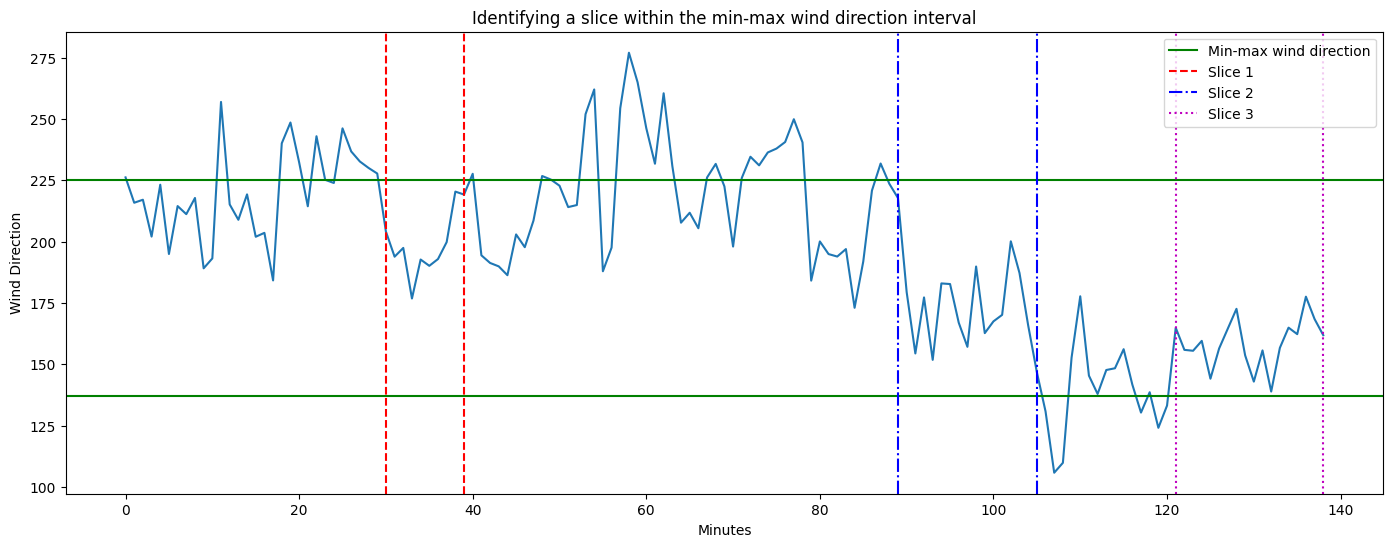

In [10]:
# Selecting wind direction interval
max_wind_direction = 137
min_wind_direction = 225

# Plotting the slice
upper_slice_1 = 39
lower_slice_1 = 30

upper_slice_2 = 105
lower_slice_2 = 89

upper_slice_3 = 138
lower_slice_3 = 121

# Plotting full wind direction time series to identify a slice
plt.figure(figsize=(17, 6))
plt.plot(wind_field_scr1["Average Direction"].values)
# Maximum and minimum wind directions to stay in beams
plt.axhline(y=max_wind_direction, color='g', linestyle='-', label='Min-max wind direction')
plt.axhline(y=min_wind_direction, color='g', linestyle='-')
# Slice 1
plt.axvline(x=lower_slice_1, color='r', linestyle='--', label='Slice 1')
plt.axvline(x=upper_slice_1, color='r', linestyle='--')
# Slice 2
plt.axvline(x=lower_slice_2, color='b', linestyle='dashdot', label='Slice 2')
plt.axvline(x=upper_slice_2, color='b', linestyle='dashdot')
# Slice 3
plt.axvline(x=lower_slice_3, color='m', linestyle=':', label='Slice 3')
plt.axvline(x=upper_slice_3, color='m', linestyle=':')
plt.title('Identifying a slice within the min-max wind direction interval')
plt.xlabel('Minutes')
plt.ylabel('Wind Direction')
plt.legend(loc='upper right')
plt.show()


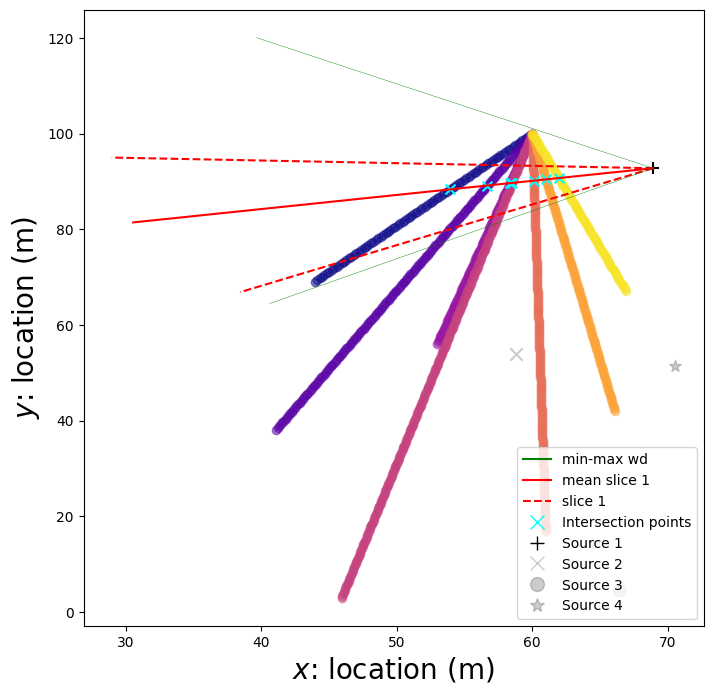

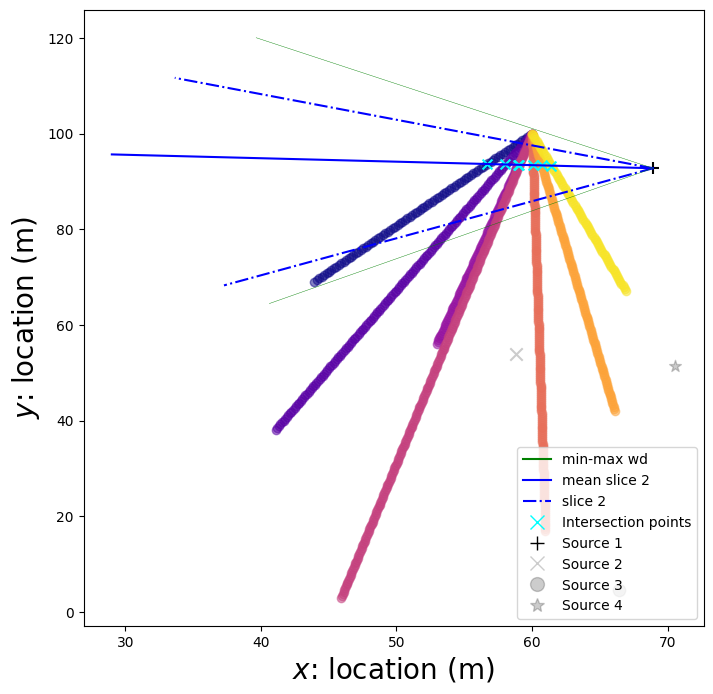

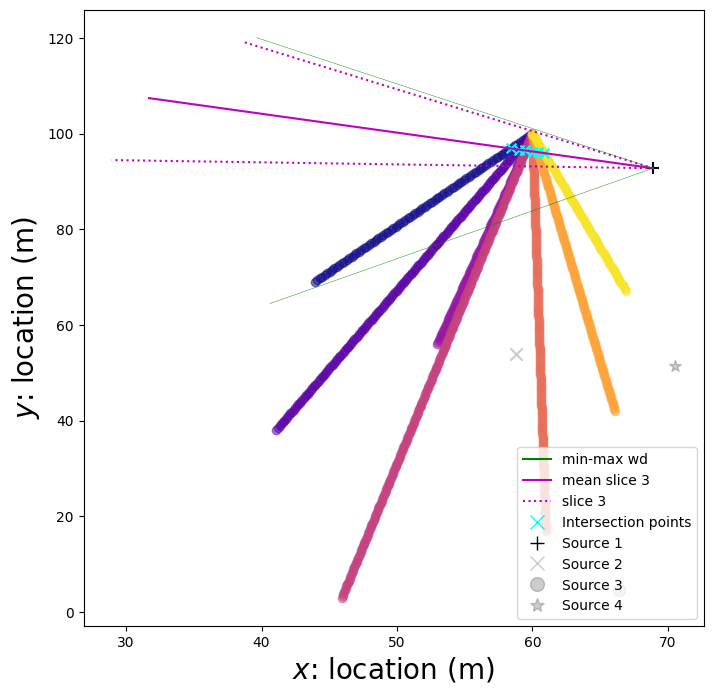

In [11]:
slice_1 = wind_field_scr1["Average Direction"].values[lower_slice_1:upper_slice_1]
slice_2 = wind_field_scr1["Average Direction"].values[lower_slice_2:upper_slice_2]
slice_3 = wind_field_scr1["Average Direction"].values[lower_slice_3:upper_slice_3]

# Selecting wind direction interval
upper_wind_direction_slice_1 = slice_1.max()
lower_wind_direction_slice_1 = slice_1.min()
upper_wind_direction_slice_2 = slice_2.max()
lower_wind_direction_slice_2 = slice_2.min()
upper_wind_direction_slice_3 = slice_3.max()
lower_wind_direction_slice_3 = slice_3.min()


# Computing mean wind direction of the slice
mean_wind_direction_slice_1 = slice_1.mean()
mean_wind_direction_slice_2 = slice_2.mean()
mean_wind_direction_slice_3 = slice_3.mean()


# Source 2 coordinates
source_1_coord = (source1_location.source_location_x, source1_location.source_location_y)

# Length of the wind direction lines in meters
length = 40

# Mean wind direction line end point
mean_wind_direction_line_end_point_slice_1 = wind_direction_line(source_1_coord, mean_wind_direction_slice_1, length)
mean_wind_direction_line_end_point_slice_2 = wind_direction_line(source_1_coord, mean_wind_direction_slice_2, length)
mean_wind_direction_line_end_point_slice_3 = wind_direction_line(source_1_coord, mean_wind_direction_slice_3, length)

beam_coordinates = [point_sensors_1_location, point_sensors_2_location, point_sensors_3_location, point_sensors_4_location, point_sensors_5_location, point_sensors_6_location, point_sensors_7_location]
mean_wd = [mean_wind_direction_slice_1, mean_wind_direction_slice_2, mean_wind_direction_slice_3]
mean_wd_line_ends = [mean_wind_direction_line_end_point_slice_1, mean_wind_direction_line_end_point_slice_2, mean_wind_direction_line_end_point_slice_3]
intersection_points = {
    "intersection_point_slice_1": [],
    "intersection_point_slice_2": [],
    "intersection_point_slice_3": [],
}

distances = {
    "distance_slice_1": [],
    "distance_slice_2": [],
    "distance_slice_3": [],
}
for mean_wd_line_end, mean_wd, intrsctn_pnt, dstnc in zip(mean_wd_line_ends, mean_wd, intersection_points.keys(), distances.keys()):
    for beam in beam_coordinates:
        intersection_point, distance = line_intersection_and_distance(line1_point1 = source_1_coord,
                                            line1_point2 = mean_wd_line_end,
                                            line2_point1 = (beam[0][0], beam[0][1]),
                                            line2_point2 = (beam[-1][0], beam[-1][1]),
                                            wind_direction = mean_wd)
        intersection_points[intrsctn_pnt].append(intersection_point)
        distances[dstnc].append(distance)


upper_wind_direction_slices = [upper_wind_direction_slice_1, upper_wind_direction_slice_2, upper_wind_direction_slice_3]
lower_wind_direction_slices = [lower_wind_direction_slice_1, lower_wind_direction_slice_2, lower_wind_direction_slice_3]
lines = ["r--", "b", "m:"]
mean_lines = ["r-", "b-", "m-"]
s = ["Source_1_slice_1", "Source_1_slice_2", "Source_1_slice_3"]
# Plotting the sources, the beam, and the mean wind direction
for upper_wind_direction_slice, lower_wind_direction_slice, inter_pnt, line, mean_line, mean_wd_line_end, s in zip(upper_wind_direction_slices, lower_wind_direction_slices, intersection_points.keys(), lines, mean_lines, mean_wd_line_ends, s):

    flat, unflat_func = ravel_pytree(intersection_points[inter_pnt])

    plt.figure(figsize=(8, 8))
    plt.scatter(sources["source_1_location"][0], sources["source_1_location"][1], color='black', marker='+', label='Source 1', s=80)
    plt.scatter(sources["source_2_location"][0], sources["source_2_location"][1], color='black', marker='x', label='Source 2', alpha=0.2, s=80)
    plt.scatter(sources["source_3_location"][0], sources["source_3_location"][1], color='black', marker='o', label='Source 3', alpha=0.2, s=80)
    plt.scatter(sources["source_4_location"][0], sources["source_4_location"][1], color='black', marker='*', label='Source 4', alpha=0.2, s=80)
    plt.scatter(60, 100, color='lightcoral', marker='.')
    colors = cm.plasma(np.linspace(0, 0.95, 7))

    # Extract x, y, z coordinates
    x_coords_1 = [location[0] for location in point_sensors_1_location]
    y_coords_1 = [location[1] for location in point_sensors_1_location]

    x_coords_2 = [location[0] for location in point_sensors_2_location]
    y_coords_2 = [location[1] for location in point_sensors_2_location]

    x_coords_3 = [location[0] for location in point_sensors_3_location]
    y_coords_3 = [location[1] for location in point_sensors_3_location]

    x_coords_4 = [location[0] for location in point_sensors_4_location]
    y_coords_4 = [location[1] for location in point_sensors_4_location]

    x_coords_5 = [location[0] for location in point_sensors_5_location]
    y_coords_5 = [location[1] for location in point_sensors_5_location]

    x_coords_6 = [location[0] for location in point_sensors_6_location]
    y_coords_6 = [location[1] for location in point_sensors_6_location]

    x_coords_7 = [location[0] for location in point_sensors_7_location]
    y_coords_7 = [location[1] for location in point_sensors_7_location]


    # Plot the sensor locations
    plt.scatter(x_coords_1, y_coords_1, alpha=0.5, color=colors[0])
    plt.scatter(x_coords_2, y_coords_2, alpha=0.5, color=colors[1])
    plt.scatter(x_coords_3, y_coords_3, alpha=0.5, color=colors[2])
    plt.scatter(x_coords_4, y_coords_4, alpha=0.5, color=colors[3])
    plt.scatter(x_coords_5, y_coords_5, alpha=0.5, color=colors[4])
    plt.scatter(x_coords_6, y_coords_6, alpha=0.5, color=colors[5])
    plt.scatter(x_coords_7, y_coords_7, alpha=0.5, color=colors[6])

    # Min_max wind direction line
    max_wind_direction_line_end_point = wind_direction_line(source_1_coord, max_wind_direction, length)
    min_wind_direction_line_end_point = wind_direction_line(source_1_coord, min_wind_direction, length)
    # Slice wind direction line
    slice_upper_wind_direction_line_end_point = wind_direction_line(source_1_coord, upper_wind_direction_slice, length)
    slice_lower_wind_direction_line_end_point = wind_direction_line(source_1_coord, lower_wind_direction_slice, length)


    # Plot the slice wind direction lines
    plt.plot([source_1_coord[0], mean_wd_line_end[0]], [source_1_coord[1], mean_wd_line_end[1]], mean_line)
    if line == "b":
        plt.plot([source_1_coord[0], slice_upper_wind_direction_line_end_point[0]], [source_1_coord[1], slice_upper_wind_direction_line_end_point[1]], line, ls="dashdot")
        plt.plot([source_1_coord[0], slice_lower_wind_direction_line_end_point[0]], [source_1_coord[1], slice_lower_wind_direction_line_end_point[1]], line, ls="dashdot")
    else:
        plt.plot([source_1_coord[0], slice_upper_wind_direction_line_end_point[0]], [source_1_coord[1], slice_upper_wind_direction_line_end_point[1]], line)
        plt.plot([source_1_coord[0], slice_lower_wind_direction_line_end_point[0]], [source_1_coord[1], slice_lower_wind_direction_line_end_point[1]], line)
    # Plot the min-max wind direction line
    plt.plot([source_1_coord[0], min_wind_direction_line_end_point[0]], [source_1_coord[1], min_wind_direction_line_end_point[1]], 'g-', lw=0.3)
    plt.plot([source_1_coord[0], max_wind_direction_line_end_point[0]], [source_1_coord[1], max_wind_direction_line_end_point[1]], 'g-', lw=0.3)
    
    # Plot intersection points
    for i in range(int(flat.shape[0]/2)):
        if i == 0:
            plt.scatter(flat[i*2], flat[i*2+1], color='cyan', marker='x', s=50, label = 'Intersection points')
        else:
            plt.scatter(flat[i*2], flat[i*2+1], color='cyan', marker='x', s=50)
    plt.xlabel("$x$: location (m)", fontsize=20)
    plt.ylabel("$y$: location (m)", fontsize=20)
    plt.legend()
    if line == "r--":
        legend_elements = [ plt.Line2D([0], [0], color='g', label='min-max wd', markersize=2, linestyle='-'),
                            plt.Line2D([0], [0], color='r', label='mean slice 1', markersize=10, linestyle='-'),
                            plt.Line2D([0], [0], color='r', label='slice 1', markersize=10, linestyle='--'),
                            plt.Line2D([0], [0], marker='x', color='cyan', label='Intersection points', markersize=10, linestyle='None'),
                            plt.Line2D([0], [0], marker='+', color='black', label='Source 1', markersize=10, linestyle='None'),
                            plt.Line2D([0], [0], marker='x', color='black', label='Source 2', markersize=10, linestyle='None', alpha=0.2),
                            plt.Line2D([0], [0], marker='o', color='black', label='Source 3', markersize=10, linestyle='None', alpha=0.2),
                            plt.Line2D([0], [0], marker='*', color='black', label='Source 4', markersize=10, linestyle='None', alpha=0.2),]
    elif line == "b":
        legend_elements = [ plt.Line2D([0], [0], color='g', label='min-max wd', markersize=2, linestyle='-'),
                    plt.Line2D([0], [0], color='b', label='mean slice 2', markersize=10, linestyle='-'),
                    plt.Line2D([0], [0], color='b', label='slice 2', markersize=10, linestyle='dashdot'),
                    plt.Line2D([0], [0], marker='x', color='cyan', label='Intersection points', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='+', color='black', label='Source 1', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='x', color='black', label='Source 2', markersize=10, linestyle='None', alpha=0.2),
                    plt.Line2D([0], [0], marker='o', color='black', label='Source 3', markersize=10, linestyle='None', alpha=0.2),
                    plt.Line2D([0], [0], marker='*', color='black', label='Source 4', markersize=10, linestyle='None', alpha=0.2),]
    elif line == "m:":
        legend_elements = [ plt.Line2D([0], [0], color='g', label='min-max wd', markersize=2, linestyle='-'),
                    plt.Line2D([0], [0], color='m', label='mean slice 3', markersize=10, linestyle='-'),
                    plt.Line2D([0], [0], color='m', label='slice 3', markersize=10, linestyle=':'),
                    plt.Line2D([0], [0], marker='x', color='cyan', label='Intersection points', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='+', color='black', label='Source 1', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='x', color='black', label='Source 2', markersize=10, linestyle='None', alpha=0.2),
                    plt.Line2D([0], [0], marker='o', color='black', label='Source 3', markersize=10, linestyle='None', alpha=0.2),
                    plt.Line2D([0], [0], marker='*', color='black', label='Source 4', markersize=10, linestyle='None', alpha=0.2),]
        
    plt.legend(handles=legend_elements, loc='lower right')
    plt.savefig(str(s) + '_beam_wind coverage_intersections.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
# Obtain the CH4 measurements average for each reflector
average_CH4_per_beam = {
    "av_CH4_beam_slice_1": [],
    "av_CH4_beam_slice_2": [],
    "av_CH4_beam_slice_3": [],
}
for i in range(7):
    slice_1_CH4 = observations.values[i*wind_field_scr1.shape[0]:(i+1)*wind_field_scr1.shape[0]][lower_slice_1:upper_slice_1]
    slice_2_CH4 = observations.values[i*wind_field_scr1.shape[0]:(i+1)*wind_field_scr1.shape[0]][lower_slice_2:upper_slice_2]
    slice_3_CH4 = observations.values[i*wind_field_scr1.shape[0]:(i+1)*wind_field_scr1.shape[0]][lower_slice_3:upper_slice_3]

    average_CH4_slice_1 = slice_1_CH4.mean()
    average_CH4_slice_2 = slice_2_CH4.mean()
    average_CH4_slice_3 = slice_3_CH4.mean()

    average_CH4_per_beam["av_CH4_beam_slice_1"].append(np.array(average_CH4_slice_1))
    average_CH4_per_beam["av_CH4_beam_slice_2"].append(np.array(average_CH4_slice_2))
    average_CH4_per_beam["av_CH4_beam_slice_3"].append(np.array(average_CH4_slice_3))

    

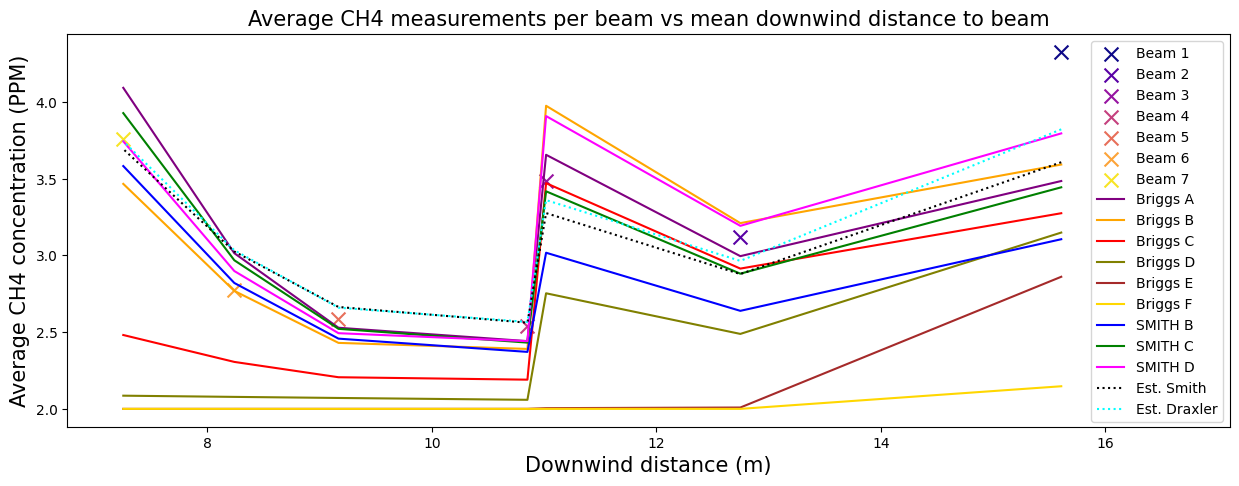

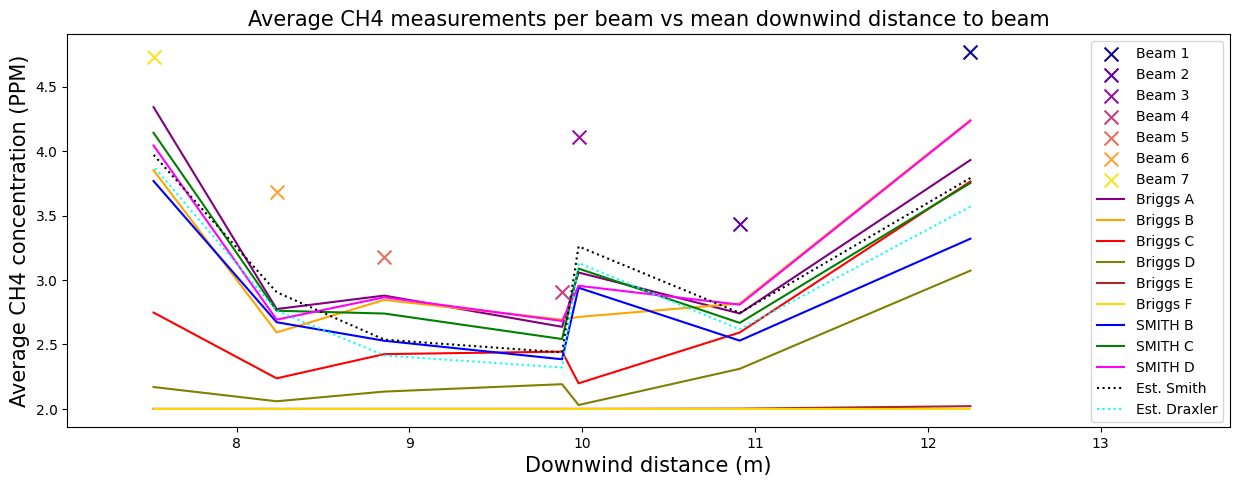

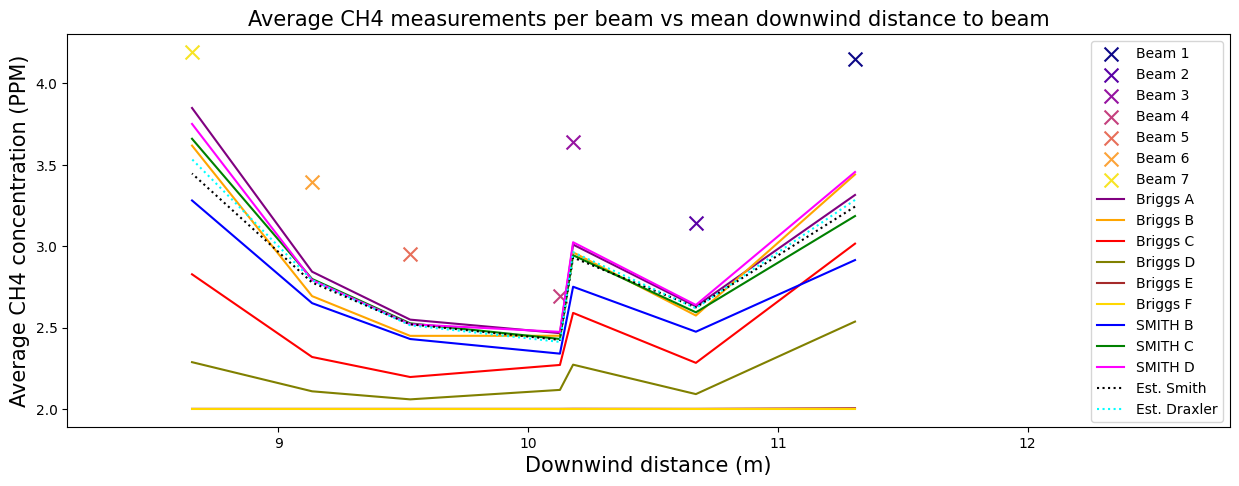

In [13]:
mean_wd = [mean_wind_direction_slice_1, mean_wind_direction_slice_2, mean_wind_direction_slice_3]
lower_slices = [lower_slice_1, lower_slice_2, lower_slice_3]
upper_slices = [upper_slice_1, upper_slice_2, upper_slice_3]
slices = [slice_1, slice_2, slice_3]
slice_str = ["av_CH4_beam_slice_1", "av_CH4_beam_slice_2", "av_CH4_beam_slice_3"]
distance_str = ["distance_slice_1", "distance_slice_2", "distance_slice_3"]
s = ["Source_1_slice_1", "Source_1_slice_2", "Source_1_slice_3"]
for mean_wind_direction, lower_slice, upper_slice, slice, slice_str, distance_str, s in zip(mean_wd, lower_slices, upper_slices, slices, slice_str, distance_str, s):
    # Computing the mean wind speed
    wind_speed = fixed_ref1[0][lower_slice:upper_slice]
    # Mean wind direction
    wind_direction = fixed_ref1[1][lower_slice:upper_slice]
    # Point sensors along LDS
    tan_gamma_horizontal = fixed_ref1[7][lower_slice:upper_slice]
    tan_gamma_vertical = fixed_ref1[8][lower_slice:upper_slice]

    fix_ref1 = jnp.tile(wind_speed, int(fixed_ref1[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref1[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_1_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_1_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_1_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref1[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref1[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \

    fix_ref2 = jnp.tile(wind_speed, int(fixed_ref2[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref2[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_2_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_2_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_2_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref2[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref2[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \

    fix_ref3 = jnp.tile(wind_speed, int(fixed_ref3[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref3[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_3_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_3_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_3_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref3[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref3[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \

    fix_ref4 = jnp.tile(wind_speed, int(fixed_ref4[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref4[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_4_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_4_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_4_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref4[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref4[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \

    fix_ref5 = jnp.tile(wind_speed, int(fixed_ref5[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref5[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_5_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_5_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_5_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref5[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref5[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \

    fix_ref6 = jnp.tile(wind_speed, int(fixed_ref6[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref6[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_6_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_6_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_6_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref6[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref6[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \

    fix_ref7 = jnp.tile(wind_speed, int(fixed_ref7[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref7[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_7_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_7_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_7_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref7[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref7[0].shape[0]/wind_field_scr1.shape[0])).reshape(-1,1), \

    x, y = jnp.array(source1_location.source_location_x), jnp.array(source1_location.source_location_y)
    schemes = ["Briggs", "Briggs", "Briggs", "Briggs", "Briggs", "Briggs", "SMITH", "SMITH", "SMITH"]
    stability_classes = ["A", "B", "C", "D", "E", "F", "B", "C", "D"]
    delta_Rs = {
        "delta_R_Briggs_A": [],
        "delta_R_Briggs_B": [],
        "delta_R_Briggs_C": [],
        "delta_R_Briggs_D": [],
        "delta_R_Briggs_E": [],
        "delta_R_Briggs_F": [],
        "delta_R_SMITH_B": [],
        "delta_R_SMITH_C": [],
        "delta_R_SMITH_D": [],
        "delta_R_SMITH_E": [],
        "delta_R_Draxler": [],
    }

    av_y_preds = {
        "av_y_pred_Briggs_A": [],
        "av_y_pred_Briggs_B": [],
        "av_y_pred_Briggs_C": [],
        "av_y_pred_Briggs_D": [],
        "av_y_pred_Briggs_E": [],
        "av_y_pred_Briggs_F": [],
        "av_y_pred_SMITH_B": [],
        "av_y_pred_SMITH_C": [],
        "av_y_pred_SMITH_D": [],
        "av_y_pred_SMITH_E": [],
        "av_y_pred_Draxler": [],
    }

    for scheme, stab_class, delta_R, av_y_pred in zip(schemes, stability_classes, delta_Rs.keys(), av_y_preds.keys()):
        coupling_matrix_ref1 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref1, x, y, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref2 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref2, x, y, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref3 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref3, x, y, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref4 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref4, x, y, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)    
        coupling_matrix_ref5 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref5, x, y, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref6 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref6, x, y, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref7 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref7, x, y, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)

        reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(slice.shape[0],18*5, order='F')
        reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(slice.shape[0],33*5, order='F')
        reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(slice.shape[0],22*5, order='F')
        reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(slice.shape[0],49*5, order='F')
        reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(slice.shape[0],42*5, order='F')
        reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(slice.shape[0],29*5, order='F')
        reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(slice.shape[0],17*5, order='F')

        path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
        path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
        path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
        path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
        path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
        path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
        path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)

        path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
        A = jnp.array(path_averaged_A).reshape(-1,1)

        y_pred = jnp.matmul(A, jnp.array([sources["source_1_emission_rate"]]).reshape(-1,1)) + 2.0
        # Average y_pred for each beam
        for i in range(7):
            av_y_preds[av_y_pred].append(y_pred[i*slice.shape[0]:(i+1)*slice.shape[0]].mean())
        for i, beam in enumerate(beam_coordinates):
            wind_direction_line_end_point = wind_direction_line(source_1_coord, mean_wind_direction, length)
            _, distance = line_intersection_and_distance(line1_point1 = (source1_location.source_location_x, source1_location.source_location_y),
                                                    line1_point2 = wind_direction_line_end_point,
                                                    line2_point1 = (beam[0][0], beam[0][1]),
                                                    line2_point2 = (beam[-1][0], beam[-1][1]),
                                                    wind_direction = mean_wind_direction)
            delta_Rs[delta_R].append(distance)




    burn_in = 4_000

    # Estimated Smith

    with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Estimated Smith/source1_mcmc_chains_dispersion_parameters_estimation_SMITH.pkl', 'rb') as f:
        est_Smith = pickle.load(f)

    MAP_est_Smith ={
        "a_H": jnp.mean(est_Smith["a_H"][burn_in:]),
        "a_V": jnp.mean(est_Smith["a_V"][burn_in:]),
        "b_H": jnp.mean(est_Smith["b_H"][burn_in:]),
        "b_V": jnp.mean(est_Smith["b_V"][burn_in:]),
        "source_x": jnp.mean(est_Smith["source_x"][burn_in:]),
        "source_y": jnp.mean(est_Smith["source_y"][burn_in:]),
        "s": jnp.mean(est_Smith["s"][burn_in:]),
        "sigma_squared": jnp.mean(est_Smith["sigma_squared"][burn_in:]),
        "background": jnp.mean(est_Smith["background"][burn_in:], axis=0),
    }
    coupling_matrix_ref1 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref1, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref2 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref2, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref3 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref3, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref4 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref4, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")    
    coupling_matrix_ref5 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref5, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref6 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref6, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref7 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref7, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")

    reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(slice.shape[0],18*5, order='F')
    reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(slice.shape[0],33*5, order='F')
    reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(slice.shape[0],22*5, order='F')
    reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(slice.shape[0],49*5, order='F')
    reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(slice.shape[0],42*5, order='F')
    reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(slice.shape[0],29*5, order='F')
    reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(slice.shape[0],17*5, order='F')

    path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
    path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
    path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
    path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
    path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
    path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
    path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)

    path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
    A_estimated = jnp.array(path_averaged_A).reshape(-1,1)

    y_pred_MAP_est_Smith = jnp.matmul(A_estimated, jnp.array([sources["source_1_emission_rate"]]).reshape(-1,1)) + 2.0
    # Average y_pred for each beam
    av_y_pred_MAP_est_Smith = []
    for i in range(7):
        av_y_pred_MAP_est_Smith.append(y_pred_MAP_est_Smith[i*slice.shape[0]:(i+1)*slice.shape[0]].mean())
    delta_R_MAP_est_Smith = []
    for i, beam in enumerate(beam_coordinates):
        wind_direction_line_end_point = wind_direction_line(source_1_coord, mean_wind_direction, length)
        _, distance = line_intersection_and_distance(line1_point1 = (source1_location.source_location_x, source1_location.source_location_y),
                                                line1_point2 = wind_direction_line_end_point,
                                                line2_point1 = (beam[0][0], beam[0][1]),
                                                line2_point2 = (beam[-1][0], beam[-1][1]),
                                                wind_direction = mean_wind_direction)
        delta_R_MAP_est_Smith.append(distance)


    # Estimated Draxler
        
    with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Estimated Draxler/source1_mcmc_chains_dispersion_parameters_estimation_Draxler.pkl', 'rb') as f:
        est_Draxler = pickle.load(f)

    MAP_est_Draxler = {
        "a_H": jnp.mean(est_Draxler["a_H"][burn_in:]),
        "a_V": jnp.mean(est_Draxler["a_V"][burn_in:]),
        "b_H": jnp.mean(est_Draxler["b_H"][burn_in:]),
        "b_V": jnp.mean(est_Draxler["b_V"][burn_in:]),
        "source_x": jnp.mean(est_Draxler["source_x"][burn_in:]),
        "source_y": jnp.mean(est_Draxler["source_y"][burn_in:]),
        "s": jnp.mean(est_Draxler["s"][burn_in:]),
        "sigma_squared": jnp.mean(est_Draxler["sigma_squared"][burn_in:]),
        "background": jnp.mean(est_Draxler["background"][burn_in:], axis=0),
    }

    coupling_matrix_ref1 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref1, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref2 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref2, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref3 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref3, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref4 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref4, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")    
    coupling_matrix_ref5 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref5, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref6 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref6, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref7 = gaussianplume_scr1.temporal_gridfree_coupling_matrix(fix_ref7, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")

    reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(slice.shape[0],18*5, order='F')
    reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(slice.shape[0],33*5, order='F')
    reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(slice.shape[0],22*5, order='F')
    reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(slice.shape[0],49*5, order='F')
    reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(slice.shape[0],42*5, order='F')
    reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(slice.shape[0],29*5, order='F')
    reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(slice.shape[0],17*5, order='F')

    path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
    path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
    path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
    path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
    path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
    path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
    path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)

    path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
    A_estimated = jnp.array(path_averaged_A).reshape(-1,1)

    y_pred_MAP_est_Draxler = jnp.matmul(A_estimated, jnp.array([sources["source_1_emission_rate"]]).reshape(-1,1)) + 2.0
    # Average y_pred for each beam
    av_y_pred_MAP_est_Draxler = []
    for i in range(7):
        av_y_pred_MAP_est_Draxler.append(y_pred_MAP_est_Draxler[i*slice.shape[0]:(i+1)*slice.shape[0]].mean())
    delta_R_MAP_est_Draxler = []
    for i, beam in enumerate(beam_coordinates):
        wind_direction_line_end_point = wind_direction_line(source_1_coord, mean_wind_direction, length)
        _, distance = line_intersection_and_distance(line1_point1 = (source1_location.source_location_x, source1_location.source_location_y),
                                                line1_point2 = wind_direction_line_end_point,
                                                line2_point1 = (beam[0][0], beam[0][1]),
                                                line2_point2 = (beam[-1][0], beam[-1][1]),
                                                wind_direction = mean_wind_direction)
        delta_R_MAP_est_Draxler.append(distance)
    plt.figure(figsize=(15, 5.1))
    for i in range(7):
        plt.scatter(distances[distance_str][i], average_CH4_per_beam[slice_str][i], color=cm.plasma(np.linspace(0, 0.95, 7))[i], label=f'Beam {i+1}', s=100, marker='x')
    plt.plot(delta_Rs["delta_R_Briggs_A"], av_y_preds["av_y_pred_Briggs_A"], color='purple', label='Briggs A')
    plt.plot(delta_Rs["delta_R_Briggs_B"], av_y_preds["av_y_pred_Briggs_B"], color='orange', label='Briggs B')
    plt.plot(delta_Rs["delta_R_Briggs_C"], av_y_preds["av_y_pred_Briggs_C"], color='red', label='Briggs C')
    plt.plot(delta_Rs["delta_R_Briggs_D"], av_y_preds["av_y_pred_Briggs_D"], color='olive', label='Briggs D')
    plt.plot(delta_Rs["delta_R_Briggs_E"], av_y_preds["av_y_pred_Briggs_E"], color='brown', label='Briggs E')
    plt.plot(delta_Rs["delta_R_Briggs_F"], av_y_preds["av_y_pred_Briggs_F"], color='gold', label='Briggs F')
    plt.plot(delta_Rs["delta_R_SMITH_B"], av_y_preds["av_y_pred_SMITH_B"], color='blue', label='SMITH B')
    plt.plot(delta_Rs["delta_R_SMITH_C"], av_y_preds["av_y_pred_SMITH_C"], color='green', label='SMITH C')
    plt.plot(delta_Rs["delta_R_SMITH_D"], av_y_preds["av_y_pred_SMITH_D"], color='magenta', label='SMITH D')
    plt.plot(delta_R_MAP_est_Smith, av_y_pred_MAP_est_Smith, color='black', label='Est. Smith', linestyle='dotted')
    plt.plot(delta_R_MAP_est_Draxler, av_y_pred_MAP_est_Draxler, color='cyan', label='Est. Draxler', linestyle='dotted')
    plt.ylabel('Average CH4 concentration (PPM)', fontsize=15)
    plt.xlabel('Downwind distance (m)', fontsize=15)
    plt.title('Average CH4 measurements per beam vs mean downwind distance to beam', fontsize=15)
    plt.xlim(np.array(distances[distance_str]).min()-0.5, np.array(distances[distance_str]).max()+1.5)
    plt.legend()
    plt.savefig(str(s) + '_CH4_concentration_per_reflector_vs_downwind_distance_case3.pdf', bbox_inches='tight', dpi=300)
    plt.show()

<br><br><br><br><br>

### Source 2

#### Data

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace with your own local path to source location data. The file is located in:

Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_2/...
</div>

In [14]:
# Load the data
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_2/Chilbolton_CH4_measurements_source_2.pkl', 'rb') as f:
    observations = pickle.load(f)
data_scr2 = observations.values
# Load the wind field and rolling standard deviation of the horizontal and vertical wind direction
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_2/Chilbolton_windfield_source_2.pkl', 'rb') as f:
    tangamma_ts = pickle.load(f)
    wind_field_scr2 = tangamma_ts[['Average Speed', 'Average Direction']]

#### Setting-up

In [15]:

source2_location = gp.SourceLocation(
    source_location_x = jnp.array([sources["source_2_location"][0]]),
    source_location_y = jnp.array([sources["source_2_location"][1]]),
    source_location_z = jnp.array([sources["source_2_location"][2]]), 
)


atmospheric_state = gp.AtmosphericState(
    emission_rate = jnp.array(sources["source_2_emission_rate"]), 
    source_half_width = jnp.array(1.0),                                               # source is a square of 2m side length
    max_abl = jnp.array(1000.0),
    background_mean = jnp.array(2.0),       
    background_std = jnp.array(1e-2),       
    background_seed = jnp.array(56),
    background_filter = "power_law",        
    Gaussian_filter_kernel = 1,              
    horizontal_opening_angle= 10.0,
    vertical_opening_angle = 10.0,
    a_horizontal = 1.0,
    a_vertical = 1.0,          
    b_horizontal = 1.0,         
    b_vertical = 1.0,        
)

# Gaussian plume model
gaussianplume_scr2 = gp.GaussianPlume(grid, source2_location, wind_field_scr2, atmospheric_state, sensors_settings)
fixed  = gaussianplume_scr2.fixed_objects_of_gridfree_chilbolton_coupling_matrix(simulation = False, wind_direction=wind_field_scr2["Average Direction"].values, wind_speed=wind_field_scr2["Average Speed"].values, tangamma_ts = tangamma_ts, number_of_time_steps=wind_field_scr2.shape[0])
fixed_ref1 = fixed[0], fixed[7], fixed[14], fixed[15], fixed[35], fixed[36], fixed[16], fixed[37], fixed[44]
fixed_ref2 = fixed[1], fixed[8], fixed[17], fixed[18], fixed[35], fixed[36], fixed[19], fixed[38], fixed[45]
fixed_ref3 = fixed[2], fixed[9], fixed[20], fixed[21], fixed[35], fixed[36], fixed[22], fixed[39], fixed[46]
fixed_ref4 = fixed[3], fixed[10], fixed[23], fixed[24], fixed[35], fixed[36], fixed[25], fixed[40], fixed[47]
fixed_ref5 = fixed[4], fixed[11], fixed[26], fixed[27], fixed[35], fixed[36], fixed[28], fixed[41], fixed[48]
fixed_ref6 = fixed[5], fixed[12], fixed[29], fixed[30], fixed[35], fixed[36], fixed[31], fixed[42], fixed[49]
fixed_ref7 = fixed[6], fixed[13], fixed[32], fixed[33], fixed[35], fixed[36], fixed[34], fixed[43], fixed[50]

#### Source 2 Atmospheric Stability Class Determination

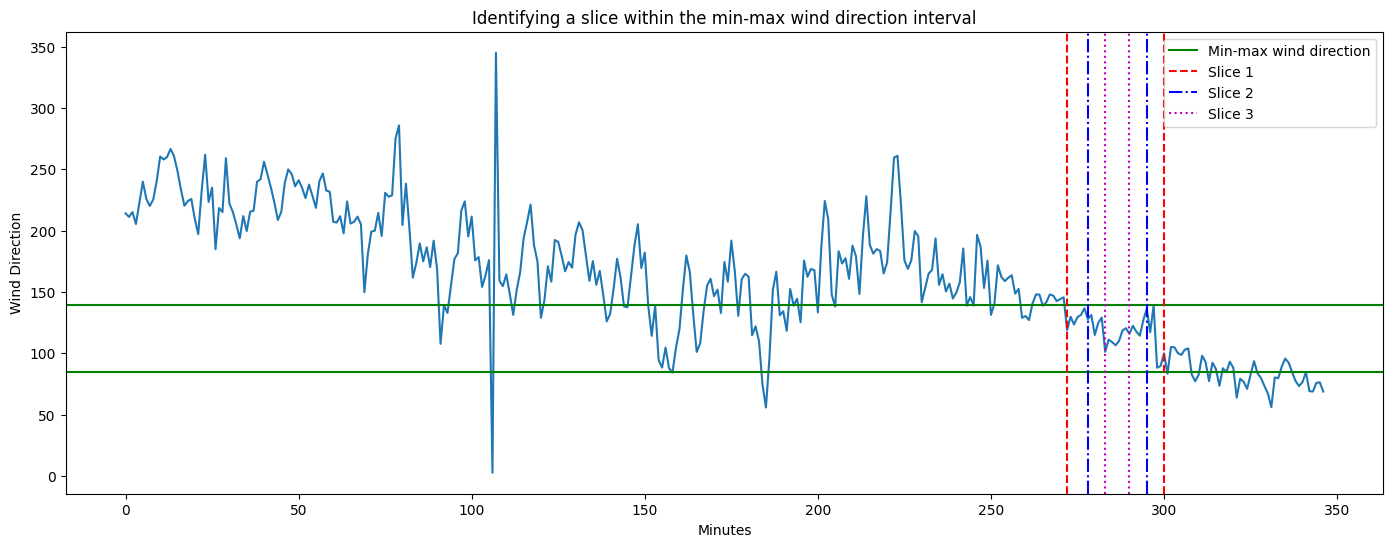

In [16]:
# Selecting wind direction interval
max_wind_direction = 139
min_wind_direction = 85

# Plotting the slice
upper_slice_1 = 300
lower_slice_1 = 272

upper_slice_2 = 295
lower_slice_2 = 278

upper_slice_3 = 290
lower_slice_3 = 283

# Plotting full wind direction time series to identify a slice
plt.figure(figsize=(17, 6))
plt.plot(wind_field_scr2["Average Direction"].values)
# Maximum and minimum wind directions to stay in beams
plt.axhline(y=max_wind_direction, color='g', linestyle='-', label='Min-max wind direction')
plt.axhline(y=min_wind_direction, color='g', linestyle='-')
# Slice 1
plt.axvline(x=lower_slice_1, color='r', linestyle='--', label='Slice 1')
plt.axvline(x=upper_slice_1, color='r', linestyle='--')
# Slice 2
plt.axvline(x=lower_slice_2, color='b', linestyle='dashdot', label='Slice 2')
plt.axvline(x=upper_slice_2, color='b', linestyle='dashdot')
# Slice 3
plt.axvline(x=lower_slice_3, color='m', linestyle=':', label='Slice 3')
plt.axvline(x=upper_slice_3, color='m', linestyle=':')
plt.title('Identifying a slice within the min-max wind direction interval')
plt.xlabel('Minutes')
plt.ylabel('Wind Direction')
plt.legend(loc='upper right')
plt.show()


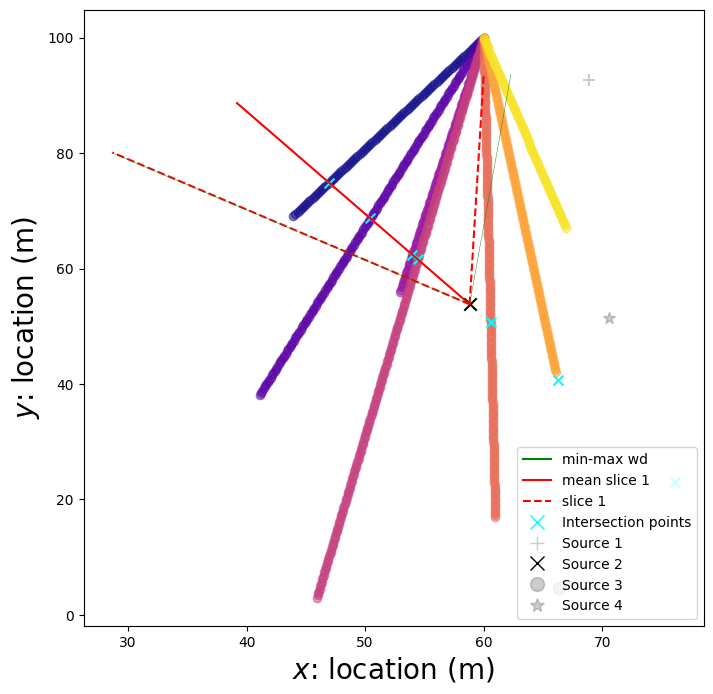

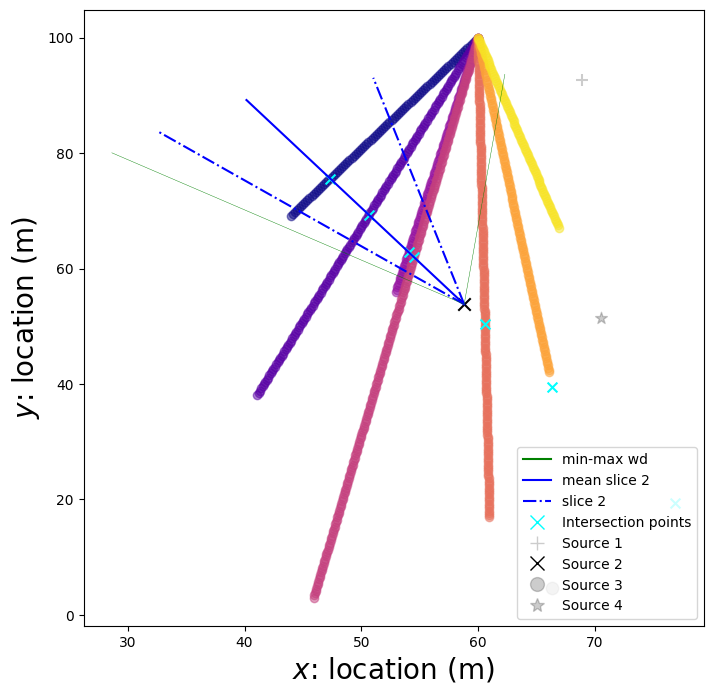

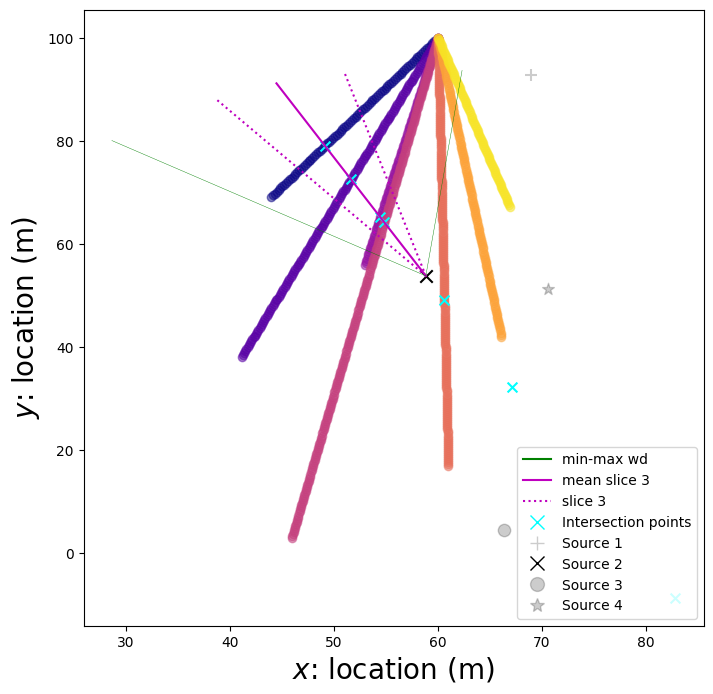

In [17]:
slice_1 = wind_field_scr2["Average Direction"].values[lower_slice_1:upper_slice_1]
slice_2 = wind_field_scr2["Average Direction"].values[lower_slice_2:upper_slice_2]
slice_3 = wind_field_scr2["Average Direction"].values[lower_slice_3:upper_slice_3]

# Selecting wind direction interval
upper_wind_direction_slice_1 = slice_1.max()
lower_wind_direction_slice_1 = slice_1.min()
upper_wind_direction_slice_2 = slice_2.max()
lower_wind_direction_slice_2 = slice_2.min()
upper_wind_direction_slice_3 = slice_3.max()
lower_wind_direction_slice_3 = slice_3.min()


# Computing mean wind direction of the slice
mean_wind_direction_slice_1 = slice_1.mean()
mean_wind_direction_slice_2 = slice_2.mean()
mean_wind_direction_slice_3 = slice_3.mean()


# Source 2 coordinates
source_2_coord = (source2_location.source_location_x, source2_location.source_location_y)

# Length of the wind direction lines in meters
length = 40

# Mean wind direction line end point
mean_wind_direction_line_end_point_slice_1 = wind_direction_line(source_2_coord, mean_wind_direction_slice_1, length)
mean_wind_direction_line_end_point_slice_2 = wind_direction_line(source_2_coord, mean_wind_direction_slice_2, length)
mean_wind_direction_line_end_point_slice_3 = wind_direction_line(source_2_coord, mean_wind_direction_slice_3, length)

beam_coordinates = [point_sensors_1_location, point_sensors_2_location, point_sensors_3_location, point_sensors_4_location, point_sensors_5_location, point_sensors_6_location, point_sensors_7_location]
mean_wd = [mean_wind_direction_slice_1, mean_wind_direction_slice_2, mean_wind_direction_slice_3]
mean_wd_line_ends = [mean_wind_direction_line_end_point_slice_1, mean_wind_direction_line_end_point_slice_2, mean_wind_direction_line_end_point_slice_3]
intersection_points = {
    "intersection_point_slice_1": [],
    "intersection_point_slice_2": [],
    "intersection_point_slice_3": [],
}

distances = {
    "distance_slice_1": [],
    "distance_slice_2": [],
    "distance_slice_3": [],
}
for mean_wd_line_end, mean_wd, intrsctn_pnt, dstnc in zip(mean_wd_line_ends, mean_wd, intersection_points.keys(), distances.keys()):
    for beam in beam_coordinates:
        intersection_point, distance = line_intersection_and_distance(line1_point1 = source_2_coord,
                                            line1_point2 = mean_wd_line_end,
                                            line2_point1 = (beam[0][0], beam[0][1]),
                                            line2_point2 = (beam[-1][0], beam[-1][1]),
                                            wind_direction = mean_wd)
        intersection_points[intrsctn_pnt].append(intersection_point)
        distances[dstnc].append(distance)


upper_wind_direction_slices = [upper_wind_direction_slice_1, upper_wind_direction_slice_2, upper_wind_direction_slice_3]
lower_wind_direction_slices = [lower_wind_direction_slice_1, lower_wind_direction_slice_2, lower_wind_direction_slice_3]
lines = ["r--", "b", "m:"]
mean_lines = ["r-", "b-", "m-"]
s = ["Source_2_slice_1", "Source_2_slice_2", "Source_2_slice_3"]
# Plotting the sources, the beam, and the mean wind direction
for upper_wind_direction_slice, lower_wind_direction_slice, inter_pnt, line, mean_line, mean_wd_line_end, s in zip(upper_wind_direction_slices, lower_wind_direction_slices, intersection_points.keys(), lines, mean_lines, mean_wd_line_ends, s):
    
    flat, unflat_func = ravel_pytree(intersection_points[inter_pnt])

    plt.figure(figsize=(8, 8))
    plt.scatter(sources["source_1_location"][0], sources["source_1_location"][1], color='black', marker='+', label='Source 1', alpha=0.2, s=80)
    plt.scatter(sources["source_2_location"][0], sources["source_2_location"][1], color='black', marker='x', label='Source 2', s=80)
    plt.scatter(sources["source_3_location"][0], sources["source_3_location"][1], color='black', marker='o', label='Source 3', alpha=0.2, s=80)
    plt.scatter(sources["source_4_location"][0], sources["source_4_location"][1], color='black', marker='*', label='Source 4', alpha=0.2, s=80)
    plt.scatter(60, 100, color='lightcoral', marker='.')
    colors = cm.plasma(np.linspace(0, 0.95, 7))

    # Extract x, y, z coordinates
    x_coords_1 = [location[0] for location in point_sensors_1_location]
    y_coords_1 = [location[1] for location in point_sensors_1_location]

    x_coords_2 = [location[0] for location in point_sensors_2_location]
    y_coords_2 = [location[1] for location in point_sensors_2_location]

    x_coords_3 = [location[0] for location in point_sensors_3_location]
    y_coords_3 = [location[1] for location in point_sensors_3_location]

    x_coords_4 = [location[0] for location in point_sensors_4_location]
    y_coords_4 = [location[1] for location in point_sensors_4_location]

    x_coords_5 = [location[0] for location in point_sensors_5_location]
    y_coords_5 = [location[1] for location in point_sensors_5_location]

    x_coords_6 = [location[0] for location in point_sensors_6_location]
    y_coords_6 = [location[1] for location in point_sensors_6_location]

    x_coords_7 = [location[0] for location in point_sensors_7_location]
    y_coords_7 = [location[1] for location in point_sensors_7_location]


    # Plot the sensor locations
    plt.scatter(x_coords_1, y_coords_1, alpha=0.5, color=colors[0])
    plt.scatter(x_coords_2, y_coords_2, alpha=0.5, color=colors[1])
    plt.scatter(x_coords_3, y_coords_3, alpha=0.5, color=colors[2])
    plt.scatter(x_coords_4, y_coords_4, alpha=0.5, color=colors[3])
    plt.scatter(x_coords_5, y_coords_5, alpha=0.5, color=colors[4])
    plt.scatter(x_coords_6, y_coords_6, alpha=0.5, color=colors[5])
    plt.scatter(x_coords_7, y_coords_7, alpha=0.5, color=colors[6])

    # Min_max wind direction line
    max_wind_direction_line_end_point = wind_direction_line(source_2_coord, max_wind_direction, length)
    min_wind_direction_line_end_point = wind_direction_line(source_2_coord, min_wind_direction, length)
    # Slice wind direction line
    slice_upper_wind_direction_line_end_point = wind_direction_line(source_2_coord, upper_wind_direction_slice, length)
    slice_lower_wind_direction_line_end_point = wind_direction_line(source_2_coord, lower_wind_direction_slice, length)


    # Plot the slice wind direction lines
    plt.plot([source_2_coord[0], mean_wd_line_end[0]], [source_2_coord[1], mean_wd_line_end[1]], mean_line)
    if line == "b":
        plt.plot([source_2_coord[0], slice_upper_wind_direction_line_end_point[0]], [source_2_coord[1], slice_upper_wind_direction_line_end_point[1]], line, ls="dashdot")
        plt.plot([source_2_coord[0], slice_lower_wind_direction_line_end_point[0]], [source_2_coord[1], slice_lower_wind_direction_line_end_point[1]], line, ls="dashdot")
    else:
        plt.plot([source_2_coord[0], slice_upper_wind_direction_line_end_point[0]], [source_2_coord[1], slice_upper_wind_direction_line_end_point[1]], line)
        plt.plot([source_2_coord[0], slice_lower_wind_direction_line_end_point[0]], [source_2_coord[1], slice_lower_wind_direction_line_end_point[1]], line)
    # Plot the min-max wind direction line
    plt.plot([source_2_coord[0], min_wind_direction_line_end_point[0]], [source_2_coord[1], min_wind_direction_line_end_point[1]], 'g-', lw=0.3)
    plt.plot([source_2_coord[0], max_wind_direction_line_end_point[0]], [source_2_coord[1], max_wind_direction_line_end_point[1]], 'g-', lw=0.3)
    
    # Plot intersection points
    for i in range(int(flat.shape[0]/2)):
        if i == 0:
            plt.scatter(flat[i*2], flat[i*2+1], color='cyan', marker='x', s=50, label = 'Intersection points')
        else:
            plt.scatter(flat[i*2], flat[i*2+1], color='cyan', marker='x', s=50)
    plt.xlabel("$x$: location (m)", fontsize=20)
    plt.ylabel("$y$: location (m)", fontsize=20)
    plt.legend()
    if line == "r--":
        legend_elements = [ plt.Line2D([0], [0], color='g', label='min-max wd', markersize=2, linestyle='-'),
                            plt.Line2D([0], [0], color='r', label='mean slice 1', markersize=10, linestyle='-'),
                            plt.Line2D([0], [0], color='r', label='slice 1', markersize=10, linestyle='--'),
                            plt.Line2D([0], [0], marker='x', color='cyan', label='Intersection points', markersize=10, linestyle='None'),
                            plt.Line2D([0], [0], marker='+', color='black', label='Source 1', markersize=10, linestyle='None', alpha=0.2),
                            plt.Line2D([0], [0], marker='x', color='black', label='Source 2', markersize=10, linestyle='None'),
                            plt.Line2D([0], [0], marker='o', color='black', label='Source 3', markersize=10, linestyle='None', alpha=0.2),
                            plt.Line2D([0], [0], marker='*', color='black', label='Source 4', markersize=10, linestyle='None', alpha=0.2),]
    elif line == "b":
        legend_elements = [ plt.Line2D([0], [0], color='g', label='min-max wd', markersize=2, linestyle='-'),
                    plt.Line2D([0], [0], color='b', label='mean slice 2', markersize=10, linestyle='-'),
                    plt.Line2D([0], [0], color='b', label='slice 2', markersize=10, linestyle='dashdot'),
                    plt.Line2D([0], [0], marker='x', color='cyan', label='Intersection points', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='+', color='black', label='Source 1', markersize=10, linestyle='None', alpha=0.2),
                    plt.Line2D([0], [0], marker='x', color='black', label='Source 2', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='o', color='black', label='Source 3', markersize=10, linestyle='None', alpha=0.2),
                    plt.Line2D([0], [0], marker='*', color='black', label='Source 4', markersize=10, linestyle='None', alpha=0.2),]
    elif line == "m:":
        legend_elements = [ plt.Line2D([0], [0], color='g', label='min-max wd', markersize=2, linestyle='-'),
                    plt.Line2D([0], [0], color='m', label='mean slice 3', markersize=10, linestyle='-'),
                    plt.Line2D([0], [0], color='m', label='slice 3', markersize=10, linestyle=':'),
                    plt.Line2D([0], [0], marker='x', color='cyan', label='Intersection points', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='+', color='black', label='Source 1', markersize=10, linestyle='None', alpha=0.2),
                    plt.Line2D([0], [0], marker='x', color='black', label='Source 2', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='o', color='black', label='Source 3', markersize=10, linestyle='None', alpha=0.2),
                    plt.Line2D([0], [0], marker='*', color='black', label='Source 4', markersize=10, linestyle='None', alpha=0.2),]
        
    plt.legend(handles=legend_elements, loc='lower right')
    plt.savefig(str(s) + '_beam_wind coverage_intersections.pdf', dpi=300, bbox_inches='tight')
    plt.show()

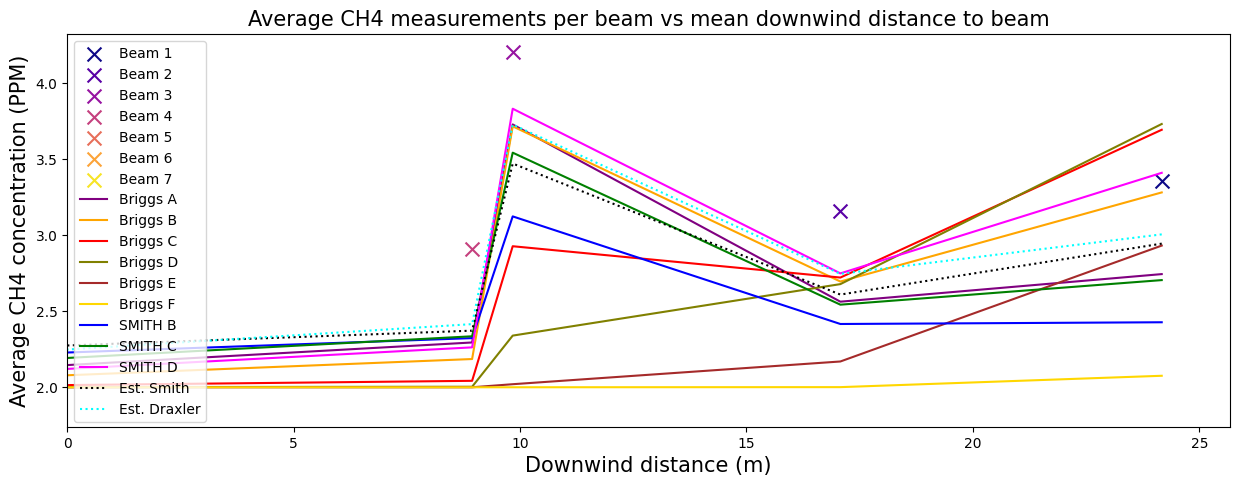

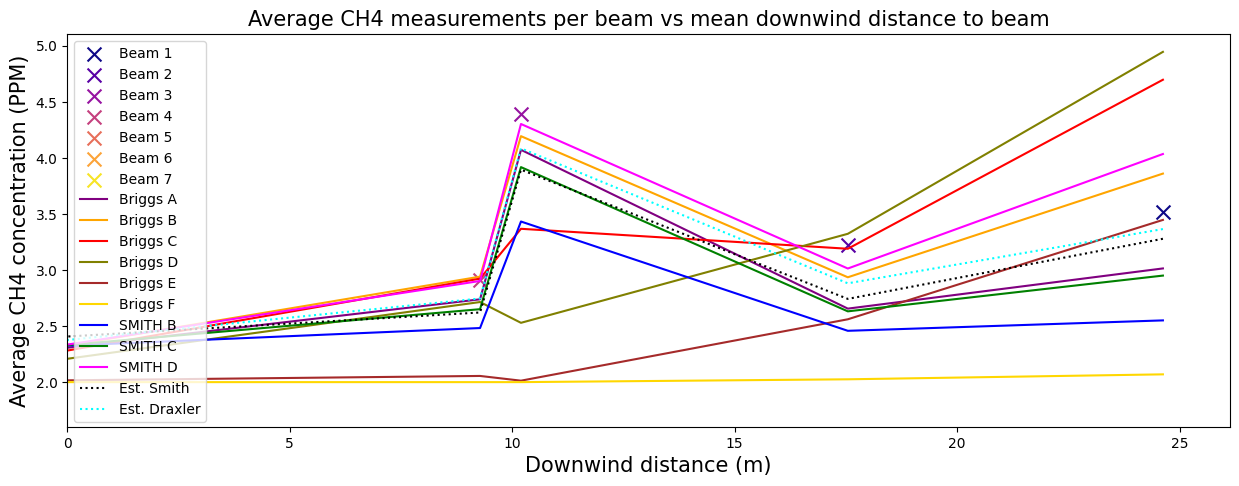

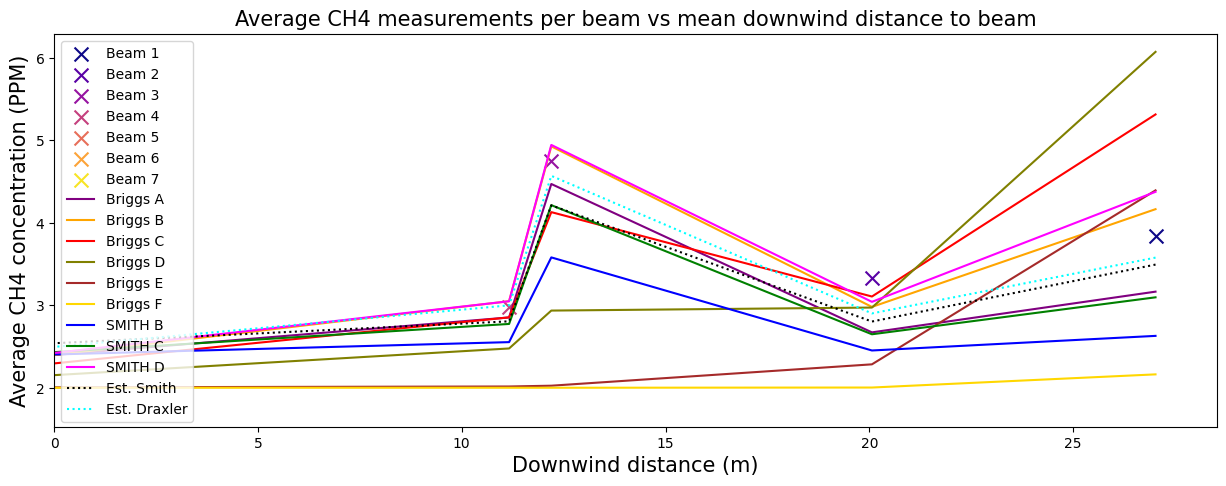

In [18]:
# Obtain the CH4 measurements average for each reflector
average_CH4_per_beam = {
    "av_CH4_beam_slice_1": [],
    "av_CH4_beam_slice_2": [],
    "av_CH4_beam_slice_3": [],
}
for i in range(7):
    slice_1_CH4 = observations.values[i*wind_field_scr2.shape[0]:(i+1)*wind_field_scr2.shape[0]][lower_slice_1:upper_slice_1]
    slice_2_CH4 = observations.values[i*wind_field_scr2.shape[0]:(i+1)*wind_field_scr2.shape[0]][lower_slice_2:upper_slice_2]
    slice_3_CH4 = observations.values[i*wind_field_scr2.shape[0]:(i+1)*wind_field_scr2.shape[0]][lower_slice_3:upper_slice_3]

    average_CH4_slice_1 = slice_1_CH4.mean()
    average_CH4_slice_2 = slice_2_CH4.mean()
    average_CH4_slice_3 = slice_3_CH4.mean()

    average_CH4_per_beam["av_CH4_beam_slice_1"].append(np.array(average_CH4_slice_1))
    average_CH4_per_beam["av_CH4_beam_slice_2"].append(np.array(average_CH4_slice_2))
    average_CH4_per_beam["av_CH4_beam_slice_3"].append(np.array(average_CH4_slice_3))

    
mean_wd = [mean_wind_direction_slice_1, mean_wind_direction_slice_2, mean_wind_direction_slice_3]
lower_slices = [lower_slice_1, lower_slice_2, lower_slice_3]
upper_slices = [upper_slice_1, upper_slice_2, upper_slice_3]
slices = [slice_1, slice_2, slice_3]
slice_str = ["av_CH4_beam_slice_1", "av_CH4_beam_slice_2", "av_CH4_beam_slice_3"]
distance_str = ["distance_slice_1", "distance_slice_2", "distance_slice_3"]
s = ["Source_2_slice_1", "Source_2_slice_2", "Source_2_slice_3"]
for mean_wind_direction, lower_slice, upper_slice, slice, slice_str, distance_str, s in zip(mean_wd, lower_slices, upper_slices, slices, slice_str, distance_str, s):
    # Computing the mean wind speed
    wind_speed = fixed_ref1[0][lower_slice:upper_slice]
    # Mean wind direction
    wind_direction = fixed_ref1[1][lower_slice:upper_slice]
    # Point sensors along LDS
    tan_gamma_horizontal = fixed_ref1[7][lower_slice:upper_slice]
    tan_gamma_vertical = fixed_ref1[8][lower_slice:upper_slice]

    fix_ref1 = jnp.tile(wind_speed, int(fixed_ref1[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref1[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_1_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_1_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_1_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref1[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref1[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \

    fix_ref2 = jnp.tile(wind_speed, int(fixed_ref2[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref2[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_2_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_2_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_2_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref2[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref2[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \

    fix_ref3 = jnp.tile(wind_speed, int(fixed_ref3[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref3[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_3_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_3_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_3_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref3[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref3[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \

    fix_ref4 = jnp.tile(wind_speed, int(fixed_ref4[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref4[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_4_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_4_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_4_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref4[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref4[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \

    fix_ref5 = jnp.tile(wind_speed, int(fixed_ref5[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref5[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_5_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_5_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_5_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref5[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref5[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \

    fix_ref6 = jnp.tile(wind_speed, int(fixed_ref6[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref6[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_6_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_6_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_6_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref6[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref6[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \

    fix_ref7 = jnp.tile(wind_speed, int(fixed_ref7[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(wind_direction, int(fixed_ref7[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[0] for x in point_sensors_7_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.repeat(jnp.array([[x[1] for x in point_sensors_7_location]]), slice.shape[0]).reshape(-1,1), \
                fixed_ref1[4], \
                fixed_ref1[5], \
                jnp.repeat(jnp.array([[x[2] for x in point_sensors_7_location]]), slice.shape[0]).reshape(-1,1), \
                jnp.tile(tan_gamma_horizontal, int(fixed_ref7[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \
                jnp.tile(tan_gamma_vertical, int(fixed_ref7[0].shape[0]/wind_field_scr2.shape[0])).reshape(-1,1), \

    x, y = jnp.array(source2_location.source_location_x), jnp.array(source2_location.source_location_y)
    schemes = ["Briggs", "Briggs", "Briggs", "Briggs", "Briggs", "Briggs", "SMITH", "SMITH", "SMITH"]
    stability_classes = ["A", "B", "C", "D", "E", "F", "B", "C", "D"]
    delta_Rs = {
        "delta_R_Briggs_A": [],
        "delta_R_Briggs_B": [],
        "delta_R_Briggs_C": [],
        "delta_R_Briggs_D": [],
        "delta_R_Briggs_E": [],
        "delta_R_Briggs_F": [],
        "delta_R_SMITH_B": [],
        "delta_R_SMITH_C": [],
        "delta_R_SMITH_D": [],
        "delta_R_SMITH_E": [],
        "delta_R_Draxler": [],
    }

    av_y_preds = {
        "av_y_pred_Briggs_A": [],
        "av_y_pred_Briggs_B": [],
        "av_y_pred_Briggs_C": [],
        "av_y_pred_Briggs_D": [],
        "av_y_pred_Briggs_E": [],
        "av_y_pred_Briggs_F": [],
        "av_y_pred_SMITH_B": [],
        "av_y_pred_SMITH_C": [],
        "av_y_pred_SMITH_D": [],
        "av_y_pred_SMITH_E": [],
        "av_y_pred_Draxler": [],
    }

    for scheme, stab_class, delta_R, av_y_pred in zip(schemes, stability_classes, delta_Rs.keys(), av_y_preds.keys()):
        coupling_matrix_ref1 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref1, x, y, None, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref2 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref2, x, y, None, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref3 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref3, x, y, None, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref4 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref4, x, y, None, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)    
        coupling_matrix_ref5 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref5, x, y, None, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref6 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref6, x, y, None, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)
        coupling_matrix_ref7 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref7, x, y, None, None, None, None, None, None, simulation=False, estimated=False, scheme=scheme, stability_class=stab_class)

        reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(slice.shape[0],18*5, order='F')
        reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(slice.shape[0],33*5, order='F')
        reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(slice.shape[0],22*5, order='F')
        reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(slice.shape[0],49*5, order='F')
        reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(slice.shape[0],42*5, order='F')
        reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(slice.shape[0],29*5, order='F')
        reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(slice.shape[0],17*5, order='F')

        path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
        path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
        path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
        path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
        path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
        path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
        path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)

        path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
        A = jnp.array(path_averaged_A).reshape(-1,1)

        y_pred = jnp.matmul(A, jnp.array([sources["source_2_emission_rate"]]).reshape(-1,1)) + 2.0
        # Average y_pred for each beam
        for i in range(7):
            av_y_preds[av_y_pred].append(y_pred[i*slice.shape[0]:(i+1)*slice.shape[0]].mean())
        for i, beam in enumerate(beam_coordinates):
            wind_direction_line_end_point = wind_direction_line(source_2_coord, mean_wind_direction, length)
            _, distance = line_intersection_and_distance(line1_point1 = (source2_location.source_location_x, source2_location.source_location_y),
                                                    line1_point2 = wind_direction_line_end_point,
                                                    line2_point1 = (beam[0][0], beam[0][1]),
                                                    line2_point2 = (beam[-1][0], beam[-1][1]),
                                                    wind_direction = mean_wind_direction)
            delta_Rs[delta_R].append(distance)




    burn_in = 1_000

    # Estimated Smith

    with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Estimated Smith/source2_mcmc_chains_dispersion_parameters_estimation_SMITH.pkl', 'rb') as f:
        est_Smith = pickle.load(f)

    MAP_est_Smith ={
        "a_H": jnp.mean(est_Smith["a_H"][burn_in:]),
        "a_V": jnp.mean(est_Smith["a_V"][burn_in:]),
        "b_H": jnp.mean(est_Smith["b_H"][burn_in:]),
        "b_V": jnp.mean(est_Smith["b_V"][burn_in:]),
        "source_x": jnp.mean(est_Smith["source_x"][burn_in:]),
        "source_y": jnp.mean(est_Smith["source_y"][burn_in:]),
        "s": jnp.mean(est_Smith["s"][burn_in:]),
        "sigma_squared": jnp.mean(est_Smith["sigma_squared"][burn_in:]),
        "background": jnp.mean(est_Smith["background"][burn_in:], axis=0),
    }
    coupling_matrix_ref1 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref1, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref2 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref2, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref3 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref3, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref4 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref4, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")    
    coupling_matrix_ref5 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref5, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref6 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref6, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")
    coupling_matrix_ref7 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref7, x, y, None, MAP_est_Smith["a_H"], MAP_est_Smith["a_V"], MAP_est_Smith["b_H"], MAP_est_Smith["b_V"], simulation=False, estimated=True, scheme="SMITH")

    reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(slice.shape[0],18*5, order='F')
    reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(slice.shape[0],33*5, order='F')
    reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(slice.shape[0],22*5, order='F')
    reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(slice.shape[0],49*5, order='F')
    reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(slice.shape[0],42*5, order='F')
    reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(slice.shape[0],29*5, order='F')
    reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(slice.shape[0],17*5, order='F')

    path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
    path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
    path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
    path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
    path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
    path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
    path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)

    path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
    A_estimated = jnp.array(path_averaged_A).reshape(-1,1)

    y_pred_MAP_est_Smith = jnp.matmul(A_estimated, jnp.array([sources["source_2_emission_rate"]]).reshape(-1,1)) + 2.0
    # Average y_pred for each beam
    av_y_pred_MAP_est_Smith = []
    for i in range(7):
        av_y_pred_MAP_est_Smith.append(y_pred_MAP_est_Smith[i*slice.shape[0]:(i+1)*slice.shape[0]].mean())
    delta_R_MAP_est_Smith = []
    for i, beam in enumerate(beam_coordinates):
        wind_direction_line_end_point = wind_direction_line(source_2_coord, mean_wind_direction, length)
        _, distance = line_intersection_and_distance(line1_point1 = (source2_location.source_location_x, source2_location.source_location_y),
                                                line1_point2 = wind_direction_line_end_point,
                                                line2_point1 = (beam[0][0], beam[0][1]),
                                                line2_point2 = (beam[-1][0], beam[-1][1]),
                                                wind_direction = mean_wind_direction)
        delta_R_MAP_est_Smith.append(distance)


    # Estimated Draxler
        
    with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Estimated Draxler/source2_mcmc_chains_dispersion_parameters_estimation_Draxler.pkl', 'rb') as f:
        est_Draxler = pickle.load(f)

    MAP_est_Draxler = {
        "a_H": jnp.mean(est_Draxler["a_H"][burn_in:]),
        "a_V": jnp.mean(est_Draxler["a_V"][burn_in:]),
        "b_H": jnp.mean(est_Draxler["b_H"][burn_in:]),
        "b_V": jnp.mean(est_Draxler["b_V"][burn_in:]),
        "source_x": jnp.mean(est_Draxler["source_x"][burn_in:]),
        "source_y": jnp.mean(est_Draxler["source_y"][burn_in:]),
        "s": jnp.mean(est_Draxler["s"][burn_in:]),
        "sigma_squared": jnp.mean(est_Draxler["sigma_squared"][burn_in:]),
        "background": jnp.mean(est_Draxler["background"][burn_in:], axis=0),
    }

    coupling_matrix_ref1 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref1, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref2 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref2, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref3 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref3, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref4 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref4, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")    
    coupling_matrix_ref5 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref5, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref6 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref6, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")
    coupling_matrix_ref7 = gaussianplume_scr2.temporal_gridfree_coupling_matrix(fix_ref7, x, y, None, MAP_est_Draxler["a_H"], MAP_est_Draxler["a_V"], MAP_est_Draxler["b_H"], MAP_est_Draxler["b_V"], simulation=False, estimated=True, scheme="Draxler")

    reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(slice.shape[0],18*5, order='F')
    reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(slice.shape[0],33*5, order='F')
    reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(slice.shape[0],22*5, order='F')
    reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(slice.shape[0],49*5, order='F')
    reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(slice.shape[0],42*5, order='F')
    reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(slice.shape[0],29*5, order='F')
    reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(slice.shape[0],17*5, order='F')

    path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
    path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
    path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
    path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
    path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
    path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
    path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)

    path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
    A_estimated = jnp.array(path_averaged_A).reshape(-1,1)

    y_pred_MAP_est_Draxler = jnp.matmul(A_estimated, jnp.array([sources["source_2_emission_rate"]]).reshape(-1,1)) + 2.0
    # Average y_pred for each beam
    av_y_pred_MAP_est_Draxler = []
    for i in range(7):
        av_y_pred_MAP_est_Draxler.append(y_pred_MAP_est_Draxler[i*slice.shape[0]:(i+1)*slice.shape[0]].mean())
    delta_R_MAP_est_Draxler = []
    for i, beam in enumerate(beam_coordinates):
        wind_direction_line_end_point = wind_direction_line(source_2_coord, mean_wind_direction, length)
        _, distance = line_intersection_and_distance(line1_point1 = (source2_location.source_location_x, source2_location.source_location_y),
                                                line1_point2 = wind_direction_line_end_point,
                                                line2_point1 = (beam[0][0], beam[0][1]),
                                                line2_point2 = (beam[-1][0], beam[-1][1]),
                                                wind_direction = mean_wind_direction)
        delta_R_MAP_est_Draxler.append(distance)
    plt.figure(figsize=(15, 5.1))
    for i in range(7):
        plt.scatter(distances[distance_str][i], average_CH4_per_beam[slice_str][i], color=cm.plasma(np.linspace(0, 0.95, 7))[i], label=f'Beam {i+1}', s=100, marker='x')
    plt.plot(delta_Rs["delta_R_Briggs_A"], av_y_preds["av_y_pred_Briggs_A"], color='purple', label='Briggs A')
    plt.plot(delta_Rs["delta_R_Briggs_B"], av_y_preds["av_y_pred_Briggs_B"], color='orange', label='Briggs B')
    plt.plot(delta_Rs["delta_R_Briggs_C"], av_y_preds["av_y_pred_Briggs_C"], color='red', label='Briggs C')
    plt.plot(delta_Rs["delta_R_Briggs_D"], av_y_preds["av_y_pred_Briggs_D"], color='olive', label='Briggs D')
    plt.plot(delta_Rs["delta_R_Briggs_E"], av_y_preds["av_y_pred_Briggs_E"], color='brown', label='Briggs E')
    plt.plot(delta_Rs["delta_R_Briggs_F"], av_y_preds["av_y_pred_Briggs_F"], color='gold', label='Briggs F')
    plt.plot(delta_Rs["delta_R_SMITH_B"], av_y_preds["av_y_pred_SMITH_B"], color='blue', label='SMITH B')
    plt.plot(delta_Rs["delta_R_SMITH_C"], av_y_preds["av_y_pred_SMITH_C"], color='green', label='SMITH C')
    plt.plot(delta_Rs["delta_R_SMITH_D"], av_y_preds["av_y_pred_SMITH_D"], color='magenta', label='SMITH D')
    plt.plot(delta_R_MAP_est_Smith, av_y_pred_MAP_est_Smith, color='black', label='Est. Smith', linestyle='dotted')
    plt.plot(delta_R_MAP_est_Draxler, av_y_pred_MAP_est_Draxler, color='cyan', label='Est. Draxler', linestyle='dotted')
    plt.ylabel('Average CH4 concentration (PPM)', fontsize=15)
    plt.xlabel('Downwind distance (m)', fontsize=15)
    plt.title('Average CH4 measurements per beam vs mean downwind distance to beam', fontsize=15)
    plt.xlim(0, np.array(distances[distance_str]).max()+1.5)
    plt.legend()
    plt.savefig(str(s) + '_CH4_concentration_per_reflector_vs_downwind_distance_case3.pdf', bbox_inches='tight', dpi=300)
    plt.show()